In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('font', family='serif',size=25)

import numpy as np
import astropy.units as u
from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from scipy.stats import chi2

In [2]:
from gammapy.modeling import Fit
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.utils.random import get_random_state
 
# models modules
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    Parameter,
)
# dataset modules
from gammapy.datasets import MapDataset, Datasets
### UNBINNED one 
from UnbinnedDataset import UnbinnedDataset

from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom
from gammapy.makers import MapDatasetMaker

# SPECTRAL MODEL - POWER LAW WITH SOME WIGGLING

In [3]:
class MyCustomSpectralModel(SpectralModel):
    """My custom spectral model, parametrising a power law with some wiggling.

    Parameters
    ----------
    amplitude : `astropy.units.Quantity`
        Amplitude of the spectra model.
    index : `astropy.units.Quantity`
        Spectral index of the model.
    reference : `astropy.units.Quantity`
        Reference energy of the power law.
    a : `scalar`
        Amplitude of the wiggling.
    """

    tag = "MyCustomSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0,frozen=False)
    index = Parameter("index", 2, min=0,frozen=False)
    reference = Parameter("reference", "1 TeV", frozen=True)
    a   = Parameter("a", "4", min=0,max=30, frozen=False)
    @staticmethod
    def evaluate(energy, index, amplitude, reference, a):
        pwl = PowerLawSpectralModel.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        
        sinus  =  3 + a/10*np.sin(  (10+ 10*np.log10(energy.value) ))
        return pwl*sinus

<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde [1 / (cm2 s TeV)]'>

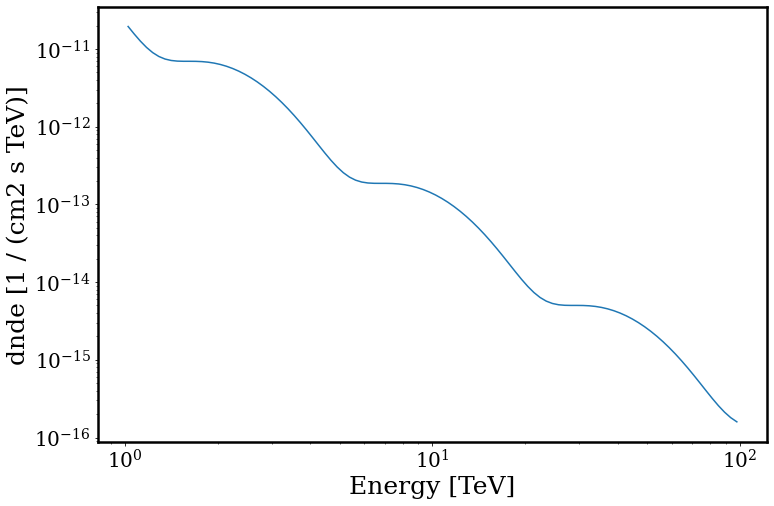

In [4]:
my_custom_model = MyCustomSpectralModel(a=15,amplitude= "1e-11  cm-2 s-1 TeV-1",index=2.5)
my_custom_model.parameters['index'].frozen = True
my_custom_model.parameters['amplitude'].frozen = True
my_custom_model.parameters['a'].frozen = False

my_custom_model2 = MyCustomSpectralModel(a=20,amplitude= "1e-12  cm-2 s-1 TeV-1",index=0.8)
my_custom_model3 = MyCustomSpectralModel(a=10,amplitude= "1e-12  cm-2 s-1 TeV-1",index=0.8)

fig, ax = plt.subplots(figsize=(12,8))
my_custom_model.plot(energy_bounds=[1, 100] * u.TeV,label="a = 10")


# SPATIAL MODEL - POINT LIKE

In [5]:
spatial_model_point = PointSpatialModel(lon_0="150.58 deg", lat_0="-13.26 deg", frame="icrs")
spatial_model_point.parameters['lon_0'].frozen = True
spatial_model_point.parameters['lat_0'].frozen = True


sky_model    = SkyModel(spectral_model=my_custom_model,spatial_model=spatial_model_point, name="point-exp-pwl")

#models              = Models( sky_model  )
bkg_model           = FoVBackgroundModel(dataset_name="my-dataset")
models              = Models([sky_model , bkg_model] )


# IRF

In [6]:
import pickle
pointing = SkyCoord(150.58 ,-13.26 , frame="icrs", unit="deg")
livetime = 1 * u.hr
with open('irfs.p', 'rb') as fp:
    irfs = pickle.load(fp)
observation = Observation.create( pointing=pointing, livetime=livetime, irfs=irfs )

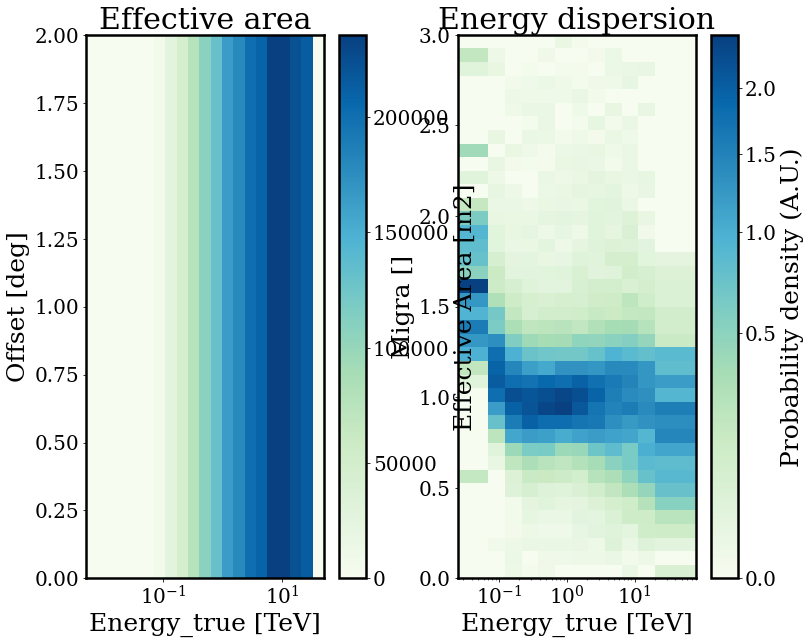

In [7]:
observation.peek()

# DATASET - BOTH UNBINNED (UnbinnedDataset) AND BINNED ( MapDataset )

In [8]:
energy_axis      = MapAxis.from_energy_bounds( "0.01 TeV", "100 TeV", nbin=45, per_decade=True, name="energy" )
energy_axis_true = MapAxis.from_energy_bounds( "0.01 TeV", "100 TeV", nbin=45, per_decade=True, name="energy_true")
migra_axis       = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

# WcsGeom
geom   = WcsGeom.create(frame="icrs", skydir=pointing, width=(2, 2), binsz=0.02, axes=[energy_axis])

# Or RegionGeom  
# but does not work for simulating events
#on_region_radius = Angle("1 deg")
#on_region        = CircleSkyRegion(center=pointing, radius=on_region_radius)
#geom             = RegionGeom.create(region=on_region, axes=[energy_axis])


maker  = MapDatasetMaker(selection=["exposure","edisp",  ]) # "background" ])#, 


#  UnbinnedDatase
d_empty                 = UnbinnedDataset.create( geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis, name="my-dataset")
unbinned_dataset        = maker.run(d_empty, observation)
unbinned_dataset.models = models
#unbinned_dataset.update_flux()
print(unbinned_dataset)



energy_axis      = MapAxis.from_energy_bounds( "0.01 TeV", "100 TeV", nbin=45, per_decade=True, name="energy" )
energy_axis_true = MapAxis.from_energy_bounds( "0.01 TeV", "100 TeV", nbin=45, per_decade=True, name="energy_true")
migra_axis       = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

# WcsGeom
geom   = WcsGeom.create(frame="icrs", skydir=pointing, width=(2, 2), binsz=0.02, axes=[energy_axis])

#  MapDatase 
d_empty                  = MapDataset.create( geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis, name="my-dataset")
dataset                  = maker.run(d_empty, observation)
print("npred")
print(dataset.npred_signal().data.sum())
dataset.models           = models
print("npred")
print(dataset.npred_signal().data.sum())
print(dataset)

UnbinnedDataset
---------------

  Name                            : my-dataset 

  Event list                      : None 
  Total counts                    : 0 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 1267.36
  Predicted background counts     : nan
  Predicted excess counts         : 1267.36

  Exposure min                    : 2.54e+02 m2 s
  Exposure max                    : 8.48e+08 m2 s

  Number of total bins            : 1800000 
  Number of fit bins              : 1800000 

  Fit statistic type              : unbinned
  Fit statistic value (-2 log(L)) : -inf

  Number of models                : 2 
  Number of parameters            : 9
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : point-exp-pwl
    Datasets names            : None
    Spectral model type       : MyCustomSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model

# EVENTS SIMULATION

In [9]:
###################################
# SIMULATING EVENTS
###################################
n_obs = 10
unbinned_datasets = Datasets()
datasets          = Datasets()

for idx in range(n_obs):
    #UNBINNED
    unbinned_dataset_fake                      = unbinned_dataset.copy(name=f"obs-{idx}")
    unbinned_dataset_fake.meta_table["OBS_ID"] = [idx]
    unbinned_dataset_fake.models               = models.copy()
    unbinned_dataset_fake.fake(bkg=False,random_state=idx) 
    unbinned_datasets.append(unbinned_dataset_fake)
    
    #BINNED
    dataset_fake                               = dataset.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"]          = [idx]
    dataset_fake.models                        = models.copy()
    # counts from the simulated events
    fake_counts                                = Map.from_geom(dataset_fake.geoms["geom"])
    fake_counts.fill_events(unbinned_dataset_fake.events)
    dataset_fake.counts                        = fake_counts
    datasets.append(dataset_fake)


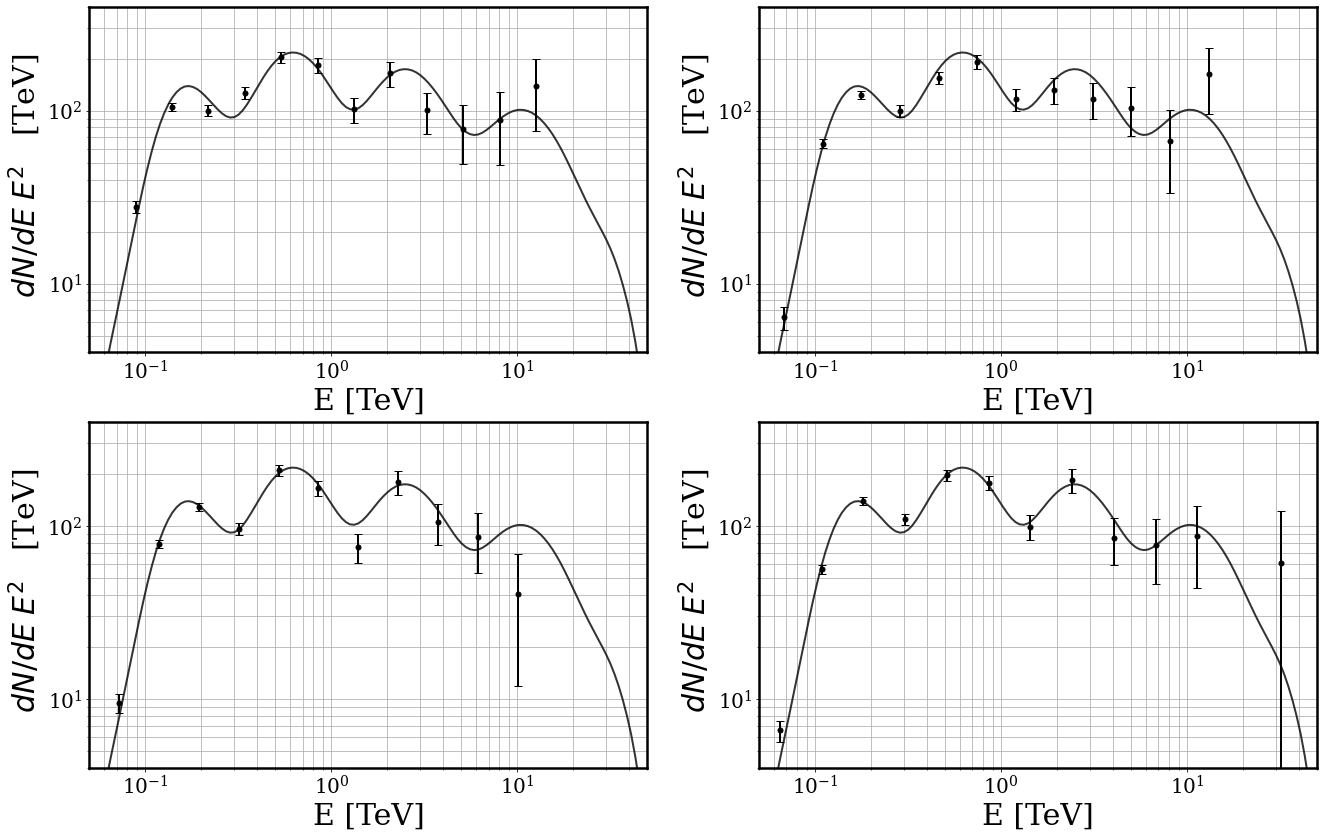

In [10]:
###################################
# SHOW SOME SMULATIONS OF THE UNBINNED DATASET
###################################


fig, axs = plt.subplots(figsize=(22,14),nrows=2, ncols=2)

for i in [0,1]:
    for j in [0,1]:
        example_dataset = unbinned_datasets[np.random.choice(n_obs )]
        #Plot Model
        plot_dict = dict(color='black',linewidth=2,alpha=0.8,label="Source dN/dE")
        ax, _     = example_dataset.plot_predicted_dnde(ax=axs[i,j],fig=fig,**plot_dict,line=True,bkg=False)
        #Plot events
        plot_dict = dict(color='black',label="Simulated source events")
        ax, _     = example_dataset.plot_observed_dnde(ax=axs[i,j],fig=fig,en_bins=14,**plot_dict)
        ax.set_ylim(bottom=4e0,top=4e2)
        ax.set_xlim([5e-2,5e1])


# FITTING WITH Fit class

In [11]:
###################################
# PERFORM THE FIT
###################################

TS_nullH_list  = []
TS_bestH_list  = []

unbinned_TS_nullH_list  = []
unbinned_TS_bestH_list  = []

unbinned_ampl_fitted_list = []
ampl_fitted_list          = []

unbinned_index_fitted_list = []
index_fitted_list          = []

unbinned_a_fitted_list = []
a_fitted_list          = []
i = 0

for unbinned_idataset, idataset in zip(unbinned_datasets, datasets):
    
    # Unbinned
    unbinned_TS_nullH_list.append(unbinned_idataset.stat_sum())
    unbinned_fit = Fit()
    result = unbinned_fit.optimize(unbinned_idataset)
    unbinned_TS_bestH_list.append(unbinned_idataset.stat_sum())
    
    print("Fit number       :", i)
    a_fitted     = result.parameters["a"].value
    index_fitted = result.parameters["index"].value
    ampl_fitted  = result.parameters["amplitude"].value
    print("Unbinned Result  : a     =", a_fitted)
    print("Unbinned Result  : index =", index_fitted)
    print("Unbinned Result  : ampl. =", ampl_fitted)
    unbinned_a_fitted_list.append(a_fitted)
    unbinned_index_fitted_list.append(index_fitted)
    unbinned_ampl_fitted_list.append(ampl_fitted)
    
    
    # Binned
    TS_nullH_list.append(idataset.stat_sum())
    fit = Fit()
    result = fit.optimize(idataset)
    TS_bestH_list.append(idataset.stat_sum())
    
    a_fitted     = result.parameters["a"].value
    index_fitted = result.parameters["index"].value
    ampl_fitted  = result.parameters["amplitude"].value
    print("Binned Result    : a     =", a_fitted)
    print("Binned Result    : index =", index_fitted)
    print("Binned Result    : ampl. =", ampl_fitted,"\n")
    a_fitted_list.append(a_fitted)
    index_fitted_list.append(index_fitted)
    ampl_fitted_list.append(ampl_fitted)

    
    i += 1

unbinned_a_fitted_list     = np.array(unbinned_a_fitted_list)
a_fitted_list              = np.array(a_fitted_list)
unbinned_index_fitted_list = np.array(unbinned_index_fitted_list)
index_fitted_list          = np.array(index_fitted_list)
unbinned_ampl_fitted_list  = np.array(unbinned_ampl_fitted_list)
ampl_fitted_list           = np.array(ampl_fitted_list)

TS_nullH_list              = np.array(TS_nullH_list)
TS_bestH_list              = np.array(TS_bestH_list)

unbinned_TS_nullH_list     = np.array(unbinned_TS_nullH_list)
unbinned_TS_bestH_list     = np.array(unbinned_TS_bestH_list)

Fit number       : 0
Unbinned Result  : a     = 14.725134719194228
Unbinned Result  : index = 2.5
Unbinned Result  : ampl. = 1e-11
Binned Result    : a     = 14.784110816783972
Binned Result    : index = 2.5
Binned Result    : ampl. = 1e-11 

Fit number       : 1
Unbinned Result  : a     = 15.893851404474777
Unbinned Result  : index = 2.5
Unbinned Result  : ampl. = 1e-11
Binned Result    : a     = 15.81668531164372
Binned Result    : index = 2.5
Binned Result    : ampl. = 1e-11 

Fit number       : 2
Unbinned Result  : a     = 12.832413948563781
Unbinned Result  : index = 2.5
Unbinned Result  : ampl. = 1e-11
Binned Result    : a     = 13.014178531021752
Binned Result    : index = 2.5
Binned Result    : ampl. = 1e-11 

Fit number       : 3
Unbinned Result  : a     = 13.374969704648548
Unbinned Result  : index = 2.5
Unbinned Result  : ampl. = 1e-11
Binned Result    : a     = 13.20349163650684
Binned Result    : index = 2.5
Binned Result    : ampl. = 1e-11 

Fit number       : 4
Unbinned 

# SHOW RESULT

## Check if the Statistic is a Chi2 variable

Text(0, 0.5, 'Binned TS')

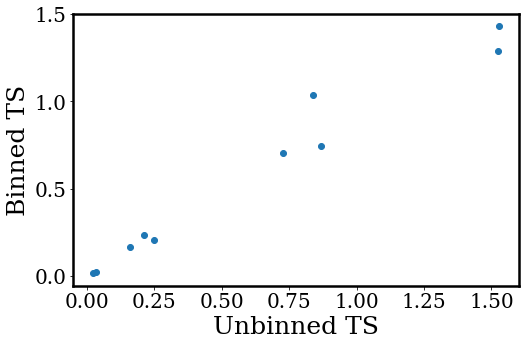

In [12]:
unbinned_TS = unbinned_TS_nullH_list - unbinned_TS_bestH_list
TS          = TS_nullH_list - TS_bestH_list

fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1)
ax.scatter(unbinned_TS, TS)
ax.set_xlabel("Unbinned TS")
ax.set_ylabel("Binned TS")

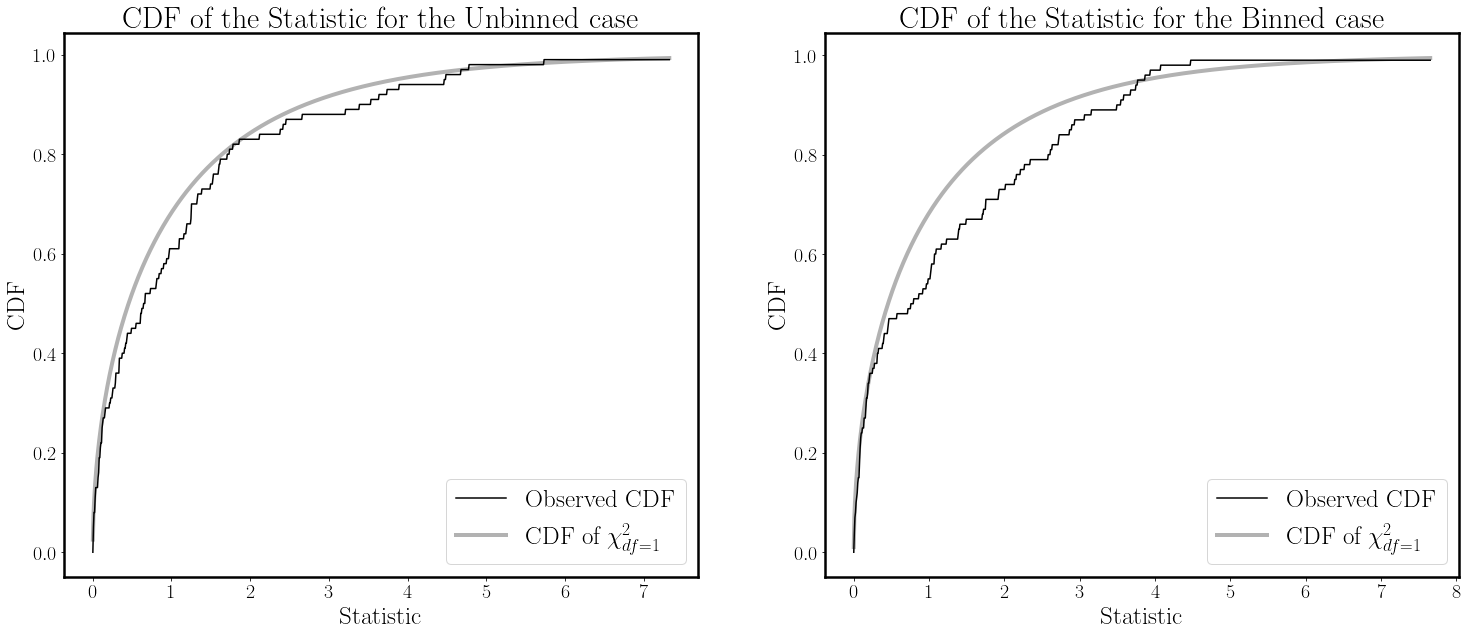

In [88]:
fig, ax = plt.subplots(figsize=(25,10),nrows=1, ncols=2)


DOF = 1 # Number of free parameters that have been fitted

min_TS      = np.min(unbinned_TS)
max_TS      = np.max(unbinned_TS)
TS_bins     = np.linspace(min_TS ,max_TS,1000)
TS_CDF      = np.array([np.sum( unbinned_TS  < i ) for i in TS_bins])/len(unbinned_TS )
ax[0].plot(TS_bins, TS_CDF , color='black', label="Observed CDF")

Chi2_CDF = chi2.cdf(TS_bins,df=DOF )
ax[0].plot(TS_bins,Chi2_CDF, color='black',alpha=0.3, linewidth=4, label=r"CDF of $\chi^2_{df = "+str(DOF) +"}$")
ax[0].set_ylabel("CDF")
ax[0].set_xlabel("Statistic")
ax[0].set_title("CDF of the Statistic for the Unbinned case")
ax[0].legend(loc="lower right")



min_TS      = np.min(TS)
max_TS      = np.max(TS)
TS_bins     = np.linspace(min_TS ,max_TS,1000)
TS_CDF      = np.array([np.sum( TS  < i ) for i in TS_bins])/len(TS )

ax[1].plot(TS_bins, TS_CDF , color='black', label="Observed CDF")

Chi2_CDF = chi2.cdf(TS_bins,df=DOF )
ax[1].plot(TS_bins,Chi2_CDF, color='black',alpha=0.3, linewidth=4, label=r"CDF of $\chi^2_{df = "+str(DOF) +"}$")
ax[1].set_ylabel("CDF")
ax[1].set_xlabel("Statistic")
ax[1].set_title("CDF of the Statistic for the Binned case")
ax[1].legend(loc="lower right")

### FOR THE PARAMETER a

Unbinned a : 15.08796943611369 += 1.8944879719277505
Binned   a : 15.515917737107582 += 2.2314570571038748


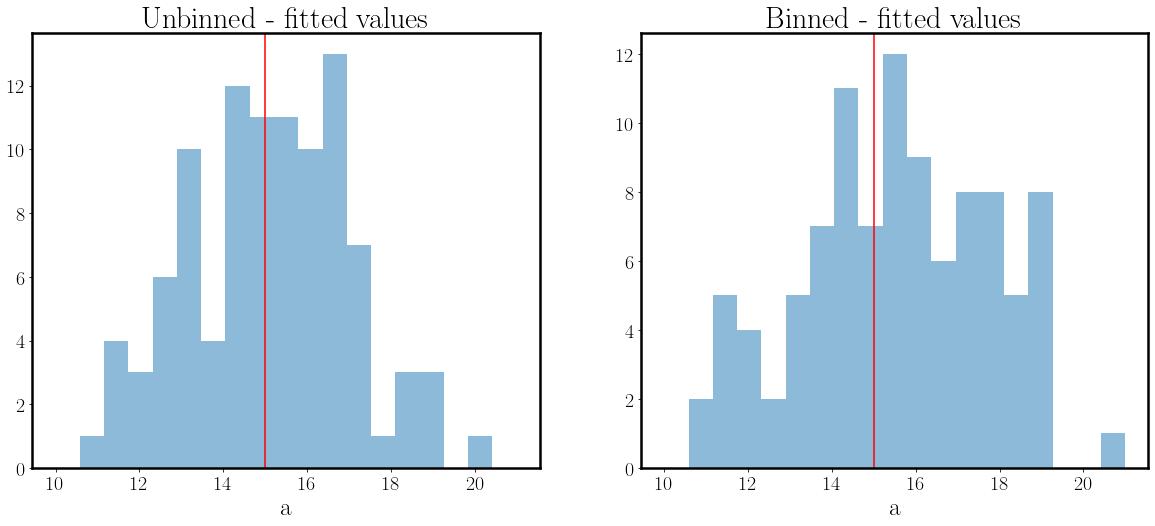

In [89]:
fig, axs = plt.subplots(figsize=(20,8),nrows=1, ncols=2)
bins = 20
bins = np.linspace(10,21,20)

true_val = my_custom_model.parameters["a"].value

axs[0].hist(unbinned_a_fitted_list, bins=bins, alpha=0.5)
axs[0].axvline(x=true_val, color="red")
axs[0].set_xlabel("a")
axs[0].set_title("Unbinned - fitted values")
print(f"Unbinned a : {unbinned_a_fitted_list.mean()} += {unbinned_a_fitted_list.std()}")

axs[1].hist(a_fitted_list, bins=bins, alpha=0.5)
axs[1].axvline(x=true_val, color="red")
axs[1].set_xlabel("a")
axs[1].set_title("Binned - fitted values")
print(f"Binned   a : {a_fitted_list.mean()} += {a_fitted_list.std()}")

Text(0, 0.5, 'a - Unbinned')

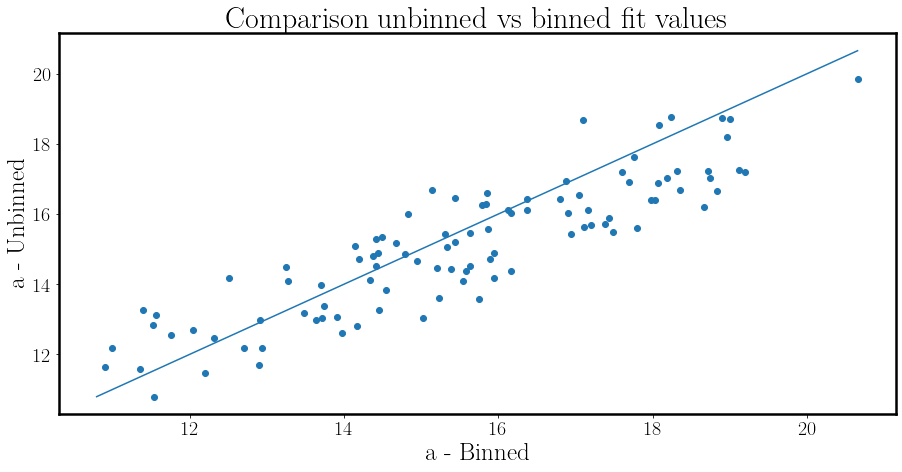

In [81]:
fig, axs = plt.subplots(figsize=(15,7),)

axs.scatter(a_fitted_list, unbinned_a_fitted_list)
x = np.linspace( np.min( [a_fitted_list, unbinned_a_fitted_list] ) ,np.max( [a_fitted_list, unbinned_a_fitted_list]) ,100)
axs.plot(x,x)
axs.set_title("Comparison unbinned vs binned fit values")
axs.set_xlabel("a - Binned")
axs.set_ylabel("a - Unbinned")

### FOR THE PARAMETER INDEX

Unbinned index : 2.5 += 0.0
Binned   index : 2.5 += 0.0


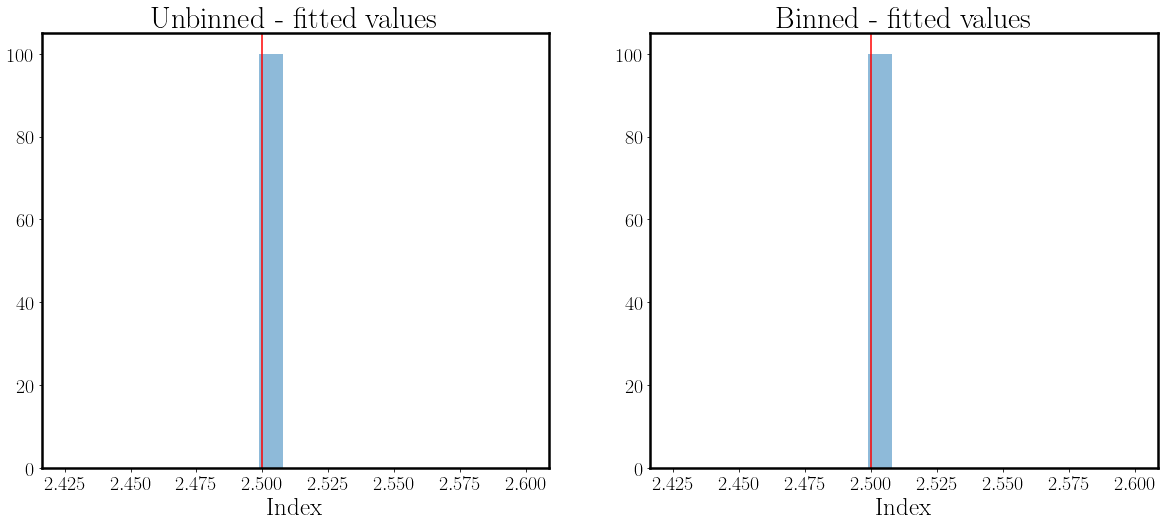

In [85]:
fig, axs = plt.subplots(figsize=(20,8),nrows=1, ncols=2)
bins = 20
bins  = np.linspace(2.425,2.60,20)

true_val = my_custom_model.parameters["index"].value

axs[0].hist(unbinned_index_fitted_list, bins=bins, alpha=0.5)
axs[0].axvline(x=true_val, color="red")
axs[0].set_xlabel("Index")
axs[0].set_title("Unbinned - fitted values")
print(f"Unbinned index : {unbinned_index_fitted_list.mean()} += {unbinned_index_fitted_list.std()}")

axs[1].hist(index_fitted_list, bins=bins, alpha=0.5)
axs[1].axvline(x=true_val, color="red")
axs[1].set_xlabel("Index")
axs[1].set_title("Binned - fitted values")
print(f"Binned   index : {index_fitted_list.mean()} += {index_fitted_list.std()}")

Text(0, 0.5, 'Index - Unbinned')

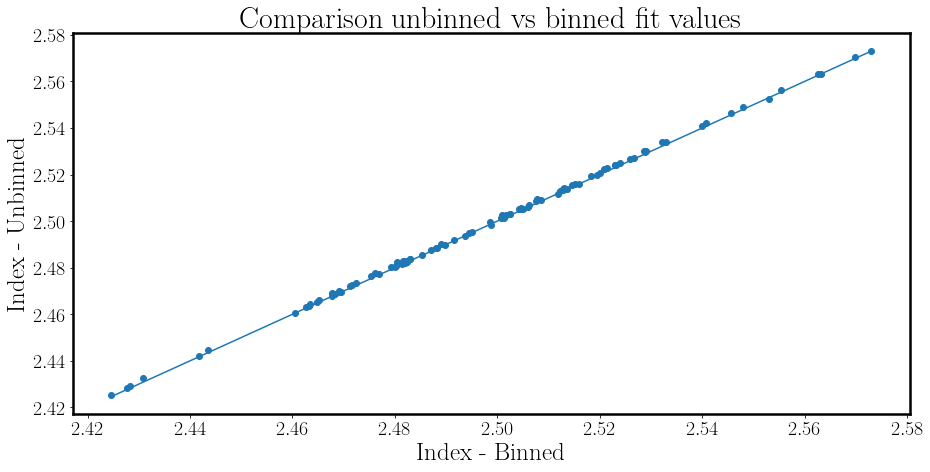

In [60]:
fig, axs = plt.subplots(figsize=(15,7),)

axs.scatter(index_fitted_list, unbinned_index_fitted_list)
x = np.linspace( np.min( [index_fitted_list, unbinned_index_fitted_list] ) ,np.max( [index_fitted_list, unbinned_index_fitted_list]) ,100)
axs.plot(x,x)
axs.set_title("Comparison unbinned vs binned fit values")
axs.set_xlabel("Index - Binned")
axs.set_ylabel("Index - Unbinned")

### FOR THE PARAMTER AMPLITUDE

Unbinned index : 1.0000000000000001e-11 += 1.6155871338926322e-27
Binned   index : 1.0000000000000001e-11 += 1.6155871338926322e-27


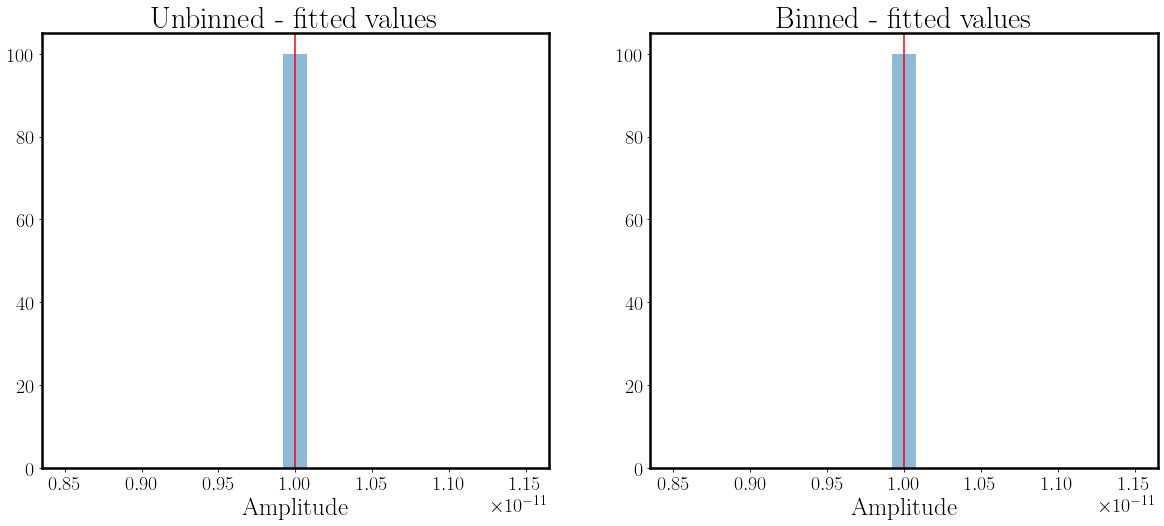

In [86]:
fig, axs = plt.subplots(figsize=(20,8),nrows=1, ncols=2)
nbins = 20
bins  = np.linspace(0.85,1.15,20)*1e-11

true_val = my_custom_model.parameters["amplitude"].value

axs[0].hist(unbinned_ampl_fitted_list, bins=bins, alpha=0.5)
axs[0].axvline(x=true_val, color="red")
axs[0].set_xlabel("Amplitude")
axs[0].set_title("Unbinned - fitted values")
print(f"Unbinned index : {unbinned_ampl_fitted_list.mean()} += {unbinned_ampl_fitted_list.std()}")

axs[1].hist(ampl_fitted_list, bins=bins, alpha=0.5)
axs[1].axvline(x=true_val, color="red")
axs[1].set_xlabel("Amplitude")
axs[1].set_title("Binned - fitted values")
print(f"Binned   index : {ampl_fitted_list.mean()} += {ampl_fitted_list.std()}")

Text(0, 0.5, 'Amplitude - Unbinned')

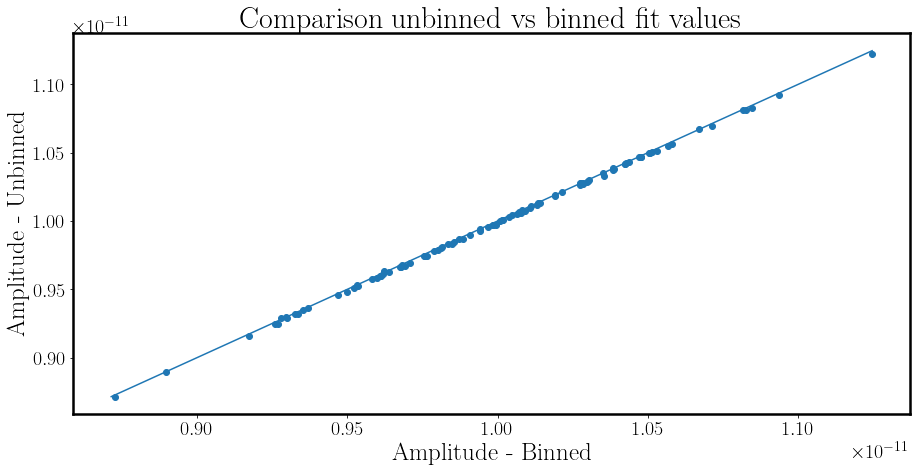

In [61]:
fig, axs = plt.subplots(figsize=(15,7),)

axs.scatter(ampl_fitted_list, unbinned_ampl_fitted_list)
x = np.linspace( np.min( [ampl_fitted_list, unbinned_ampl_fitted_list] ) ,np.max( [ampl_fitted_list, unbinned_ampl_fitted_list]) ,100)
axs.plot(x,x)
axs.set_title("Comparison unbinned vs binned fit values")
axs.set_xlabel("Amplitude - Binned")
axs.set_ylabel("Amplitude - Unbinned")